In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageChops
from scipy.fftpack import fft, fftshift, ifft
from skimage.transform import radon, rescale, iradon, rotate
from scipy.signal import hilbert, chirp

## Pregunta 1

In [2]:
# creamos una grilla con valores de x e y
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)

xx, yy = np.meshgrid(x, y)

In [3]:
def cuadrado(x, y, l):
    return (abs(x) < l / 2) & (abs(y) < l / 2)

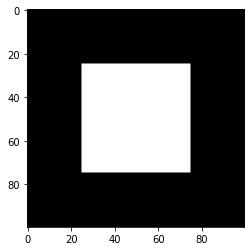

In [4]:
cuadrado = cuadrado(xx, yy, 1)
plt.imshow(cuadrado, cmap = 'gray')

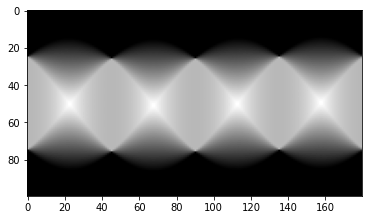

In [5]:
theta = np.linspace(0., 360., 180, endpoint=False)
sinogram = radon(cuadrado, theta=theta, preserve_range=True)
plt.imshow(sinogram, cmap='gray')

In [6]:
def circle(x, y, r):
    return x ** 2 + y ** 2 < r ** 2

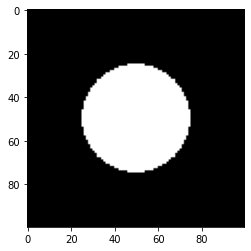

In [7]:
circulo = circle(xx, yy, 1 / 2)
plt.imshow(circulo, cmap = 'gray')

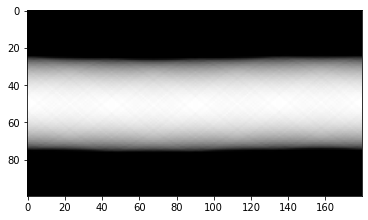

In [8]:
theta = np.linspace(0., 360., 180, endpoint = False)
sinogram = radon(circulo, theta = theta, preserve_range = True)
plt.imshow(sinogram, cmap = 'gray')

## Pregunta 2

In [9]:
def circulos(x, y, r, d = None):
    if d is None:
        return ((x - 2 * r) ** 2 + y ** 2 < r ** 2) + ((x + 2 * r) ** 2 + y ** 2 < r ** 2)
    
    return ((x - d) ** 2 + y ** 2 < r ** 2) + ((x + d) ** 2 + y ** 2 < r ** 2)

In [10]:
# creamos una grilla con valores de x e y
x_2 = np.linspace(-2, 2, 100)
y_2 = np.linspace(-2, 2, 100)

xx_2, yy_2 = np.meshgrid(x_2, y_2)

In [11]:
circles = circulos(xx_2, yy_2, 0.5)
# plt.imshow(circles, cmap = 'gray')
# plt.title(f'Discos de radio 1/2')
# plt.show()

In [12]:
theta = np.linspace(0., 360., 180, endpoint = False)
sinogram = radon(circles, theta = theta, preserve_range = True)
# plt.imshow(sinogram, cmap = 'gray')

[]

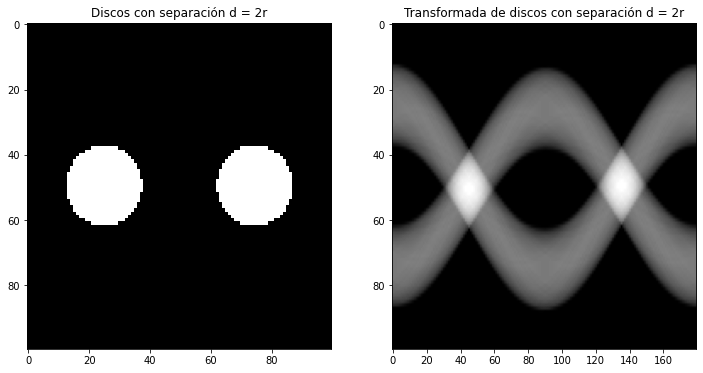

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
ax1.imshow(circles, cmap = 'gray', aspect = 'auto')
ax1.set_title(f'Discos con separación d = 2r')
ax2.imshow(sinogram, cmap = 'gray', aspect = 'auto')
ax2.set_title(f'Transformada de discos con separación d = 2r')
plt.plot()

In [14]:
r = 0.5
d = 1
theta = np.linspace(0., 360., 180, endpoint = False)

circles = circulos(xx_2, yy_2, r, d)
sinogram = radon(circles, theta = theta, preserve_range = True)

[]

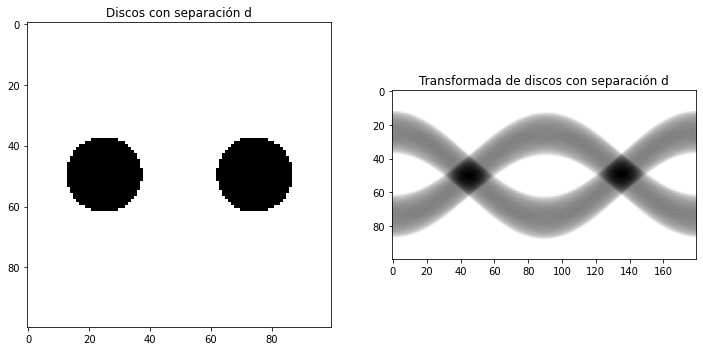

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
ax1.imshow(circles, cmap = 'binary')
ax1.set_title(f'Discos con separación d')
ax2.imshow(sinogram, cmap = 'binary')
ax2.set_title(f'Transformada de discos con separación d')
plt.plot()

c:\Users\ivanv\AppData\Local\Programs\Python\Python38\lib\site-packages\skimage\transform\radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


[]

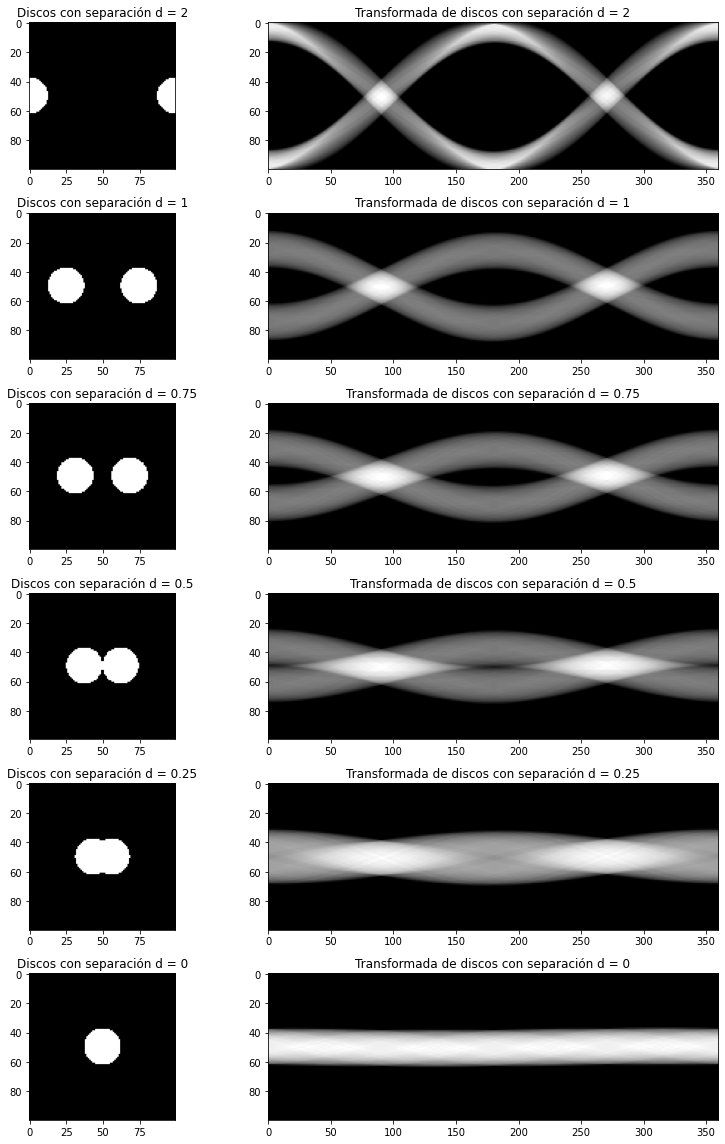

In [16]:
lista_d = (2, 1, 0.75, 0.5, 0.25, 0)
theta = np.linspace(0., 360., 360, endpoint = False)

fig, ax = plt.subplots(6, 2, figsize = (12, 16))

for i in range(len(lista_d)):
    a = lista_d[i]
    
    circles = circulos(xx_2, yy_2, r, a)
    sinogram = radon(circles, theta = theta, preserve_range = True)

    ax[i][0].imshow(circles, cmap = 'gray')
    ax[i][0].set_title(f'Discos con separación d = {a}')
    ax[i][1].imshow(sinogram, cmap = 'gray', aspect = 'auto')
    ax[i][1].set_title(f'Transformada de discos con separación d = {a}')

plt.tight_layout()
plt.plot()
    

[]

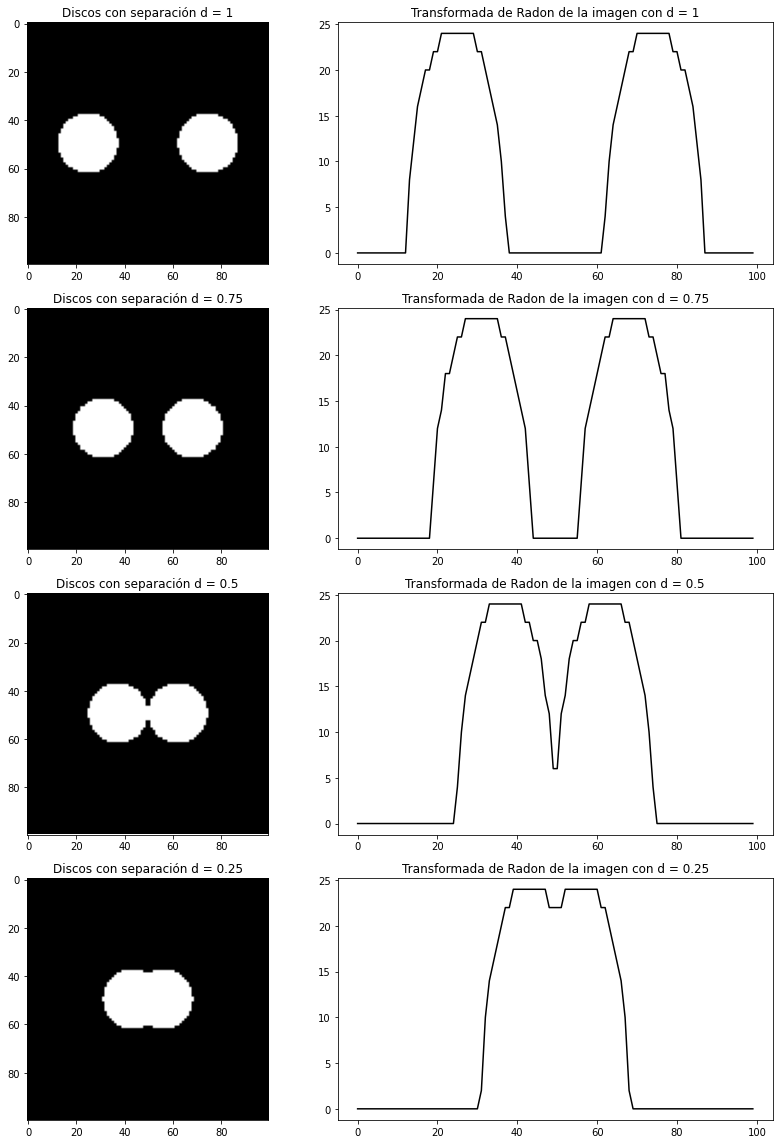

In [17]:
lista_d = (1, 0.75, 0.5, 0.25)
theta = np.linspace(0., 360., 360, endpoint = False)

fig, ax = plt.subplots(4, 2, figsize = (12, 16))

for i in range(len(lista_d)):
    a = lista_d[i]
    
    circles = circulos(xx_2, yy_2, r, a)
    sinogram = radon(circles, theta = theta, preserve_range = True)

    ax[i][0].imshow(circles, cmap = 'gray')
    ax[i][0].set_title(f'Discos con separación d = {a}')
    ax[i][1].plot(sinogram[:, 0], color = 'k')
    ax[i][1].set_title(f'Transformada de Radon de la imagen con d = {a}')

plt.tight_layout()
plt.plot()

## Pregunta 3

In [18]:
ct = np.load('ct_radon.npz')

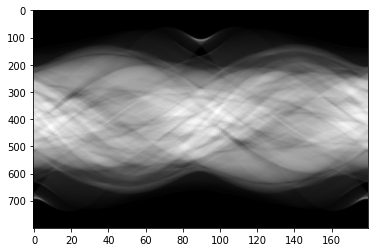

In [19]:
rx = ct['RX']
plt.imshow(rx, aspect = 'auto', cmap = 'gray')

In [20]:
theta = ct['theta']
p = ct['p']

In [21]:
theta_deg = theta * 180 / np.pi

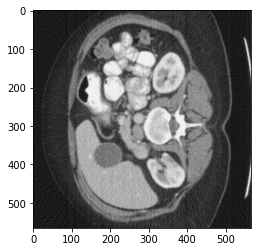

In [22]:
sinogram = iradon(rx, theta = theta_deg, circle=False, filter_name='cosine')
plt.imshow(sinogram, cmap='gray')

### 3.1 - Fourier

In [23]:
# https://github.com/csheaff/filt-back-proj/blob/633687a4a81cb306a55570752b6b9e9eefaba2a6/py/filtbackproj.py

def projFilter(sino):
    """filter projections. Normally a ramp filter multiplied by a window function is used in filtered
    backprojection. The filter function here can be adjusted by a single parameter 'a' to either approximate
    a pure ramp filter (a ~ 0)  or one that is multiplied by a sinc window with increasing cutoff frequency (a ~ 1).
    Credit goes to Wakas Aqram. 
    inputs: sino - [n x m] numpy array where n is the number of projections and m is the number of angles used.
    outputs: filtSino - [n x m] filtered sinogram array"""
    
    a = 0.1;
    projLen, numAngles = sino.shape
    step = (2 * np.pi / projLen)
    w = np.arange(-np.pi, np.pi, step)
    if len(w) < projLen:
        w = np.concatenate([w, [w[-1] + step]]) #depending on image size, it might be that len(w) =  
                                              #projLen - 1. Another element is added to w in this case
    rn1 = abs(2 / a * np.sin (a * w / 2));  #approximation of ramp filter abs(w) with a funciton abs(sin(w))
    rn2 = np.sin(a * w / 2) / (a * w / 2);   #sinc window with 'a' modifying the cutoff freqs
    r = rn1 * (rn2) ** 2;              #modulation of ramp filter with sinc window
    
    filt = fftshift(r)   
    filtSino = np.zeros((projLen, numAngles))
    for i in range(numAngles):
        projfft = fft(sino[:, i])
        filtProj = projfft * filt
        filtSino[:, i] = np.real(ifft(filtProj))

    return filtSino
        
def backproject(sinogram, theta):
    """Backprojection function. 
    inputs:  sinogram - [n x m] numpy array where n is the number of projections and m the number of angles
             theta - vector of length m denoting the angles represented in the sinogram
    output: backprojArray - [n x n] backprojected 2-D numpy array"""
    imageLen = len(p)
    reconMatrix = np.zeros((imageLen, imageLen))
    
    x = np.arange(imageLen) - imageLen / 2 #create coordinate system centered at (x,y = 0,0)
    y = x.copy()
    X, Y = np.meshgrid(x, y)

    plt.ion()
    fig2, ax = plt.subplots()
    im = plt.imshow(reconMatrix, cmap = 'gray')
    
    numAngles = len(theta)

    for n in range(numAngles):
        Xrot = X * np.sin(theta[n]) - Y * np.cos(theta[n]) #determine rotated x-coordinate about origin in mesh grid form
        XrotCor = np.round(Xrot + imageLen / 2) #shift back to original image coordinates, round values to make indices
        XrotCor = XrotCor.astype('int')
        projMatrix = np.zeros((imageLen, imageLen))
        m0, m1 = np.where((XrotCor >= 0) & (XrotCor <= (imageLen - 1))) #after rotating, you'll inevitably have new coordinates that exceed the size of the original
        s = sinogram[:, n] #get projection
        projMatrix[m0, m1] = s[XrotCor[m0, m1]]  #backproject in-bounds data
        reconMatrix += projMatrix
        im.set_data(Image.fromarray((reconMatrix - np.min(reconMatrix)) / np.ptp(reconMatrix) * 255))
        ax.set_title('Theta = %.2f degrees' % (theta[n] * 180 / np.pi))
        fig2.canvas.draw()
        fig2.canvas.flush_events()
         
    plt.close()
    plt.ioff()
    backprojArray = np.flipud(reconMatrix)
    return backprojArray

In [24]:
print('Filtering\n')
filtSino = projFilter(rx)  #numpy array
print('Performing backprojection')  

recon = backproject(filtSino, theta)
recon2 = np.round((recon - np.min(recon)) / np.ptp(recon) * 255) #convert values to integers 0-255
reconImg = Image.fromarray(recon2.astype('uint8'))
n0, n1 = p, p

Filtering

Performing backprojection


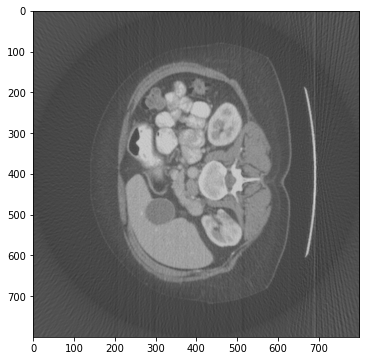

In [25]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.imshow(reconImg.rotate(90), cmap='gray')
# ax.set_title('Backprojected Image')
plt.show()

### 3.2 - Hilbert

In [26]:
# Ayudantías pasadas

def single_filtered_back_projection_hilbert(rdn, alpha_idx):
    proj = np.imag(hilbert(rdn[:, alpha_idx]))
    proj = np.tile(proj[:, np.newaxis], (1, rdn.shape[0]))
    return rotate(proj, 90 + alpha_idx / np.asarray(rdn).shape[1] * 360)
    
def filtered_back_projection_hilbert(rdn, n_alphas= -1):
    if n_alphas <= 0:
        n_alphas = np.asarray(rdn).shape[1]
    res = np.zeros((np.asarray(rdn).shape[0], np.asarray(rdn).shape[0]))
    for i in range(n_alphas):
        res += single_filtered_back_projection_hilbert(rdn, i)

    return res / np.max(res)

drx = []
rx_dv = rx.copy()
for i in range(800):
  rx_dv[i] = ((rx[i] - rx[i - 1]) / (p[i] - p[i - 2])) / (2 * np.pi)

hilbert_img = filtered_back_projection_hilbert(rx_dv)

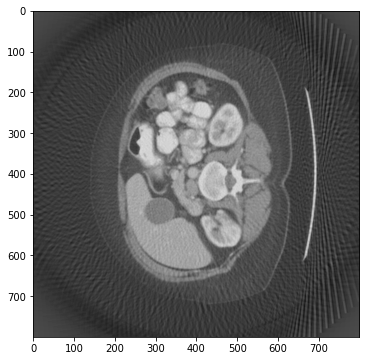

In [27]:
plt.figure(figsize = (6, 6))
plt.imshow(hilbert_img, cmap = 'binary_r')
plt.show()

### 3.3 - Suma Fourier y Hilbert

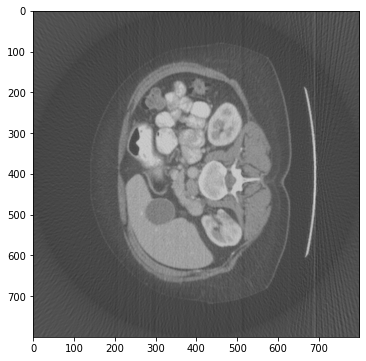

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
ax.imshow(reconImg.rotate(90) + hilbert_img, cmap='gray')
# ax.set_title('Backprojected Image')
plt.show()